In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sktime.utils.plotting import plot_series 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [153]:
"""
This function does the job to interpolate the data , set the freqency as monthly and converts the type of passengers from str to int
"""
def process_data_further(data) : 
    
    if data['PASSENGERS CARRIED'].dtype == 'object':
        data['PASSENGERS CARRIED'] = pd.to_numeric(data['PASSENGERS CARRIED'].str.replace(',', ''), errors='coerce')
    else : 
        data['PASSENGERS CARRIED'] = pd.to_numeric(data['PASSENGERS CARRIED'], errors='coerce')
    data = data.asfreq('MS')
    data.interpolate(method='linear', inplace=True)

    return data

In [154]:
#  After processing the data further , now plotting the data 
def plot_data(data) :
    data = process_data_further(data)
    plot_series(data,labels=['Passengers carried'])
    plt.title("Passengers Carried Over Time") 
    plt.show()
    return 

In [155]:
def calculate_rmse(actual, predicted):
    differences = actual - predicted
    mse = np.mean(differences**2)
    return np.sqrt(mse)

In [156]:
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [157]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [158]:
# Function to plot ACF and PACF in a 1x2 subplot
def plot_acf_pacf(data, lags):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    plot_acf(data, lags=lags, ax=ax[0])
    ax[0].set_title('Autocorrelation (ACF)')
    
    plot_pacf(data, lags=lags, ax=ax[1])
    ax[1].set_title('Partial Autocorrelation (PACF)')
    
    plt.tight_layout()
    plt.show()

In [159]:
def check_stationary(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

    return result[1]

In [160]:
def difference_data(data,d) : 
    if (d==0) :
        return data
    else :
        return difference_data(data.diff().dropna(),d-1)

In [161]:
def plotting_diffrenced_data(data,d):
    differenced_data = difference_data(data,d)
    p_values = check_stationary(differenced_data)
    return p_values , differenced_data

In [162]:
def optimal_d(data) :
    for i in range(1,6):
        p_value , diff_data = plotting_diffrenced_data(data,i)
        print(p_value)
        if p_value <= 0.0005:
            print(f"Optimal d value is {i}")
            return i 

In [163]:
def make_train_test_data(data,train_ratio):
    test_len = int(len(data) * train_ratio)
    train_data , test_data = data.iloc[:-test_len].copy() , data.iloc[-test_len:].copy()
    train_data = process_data_further(train_data)
    test_data = process_data_further(test_data)
    train_data = train_data.asfreq('MS')
    test_data = test_data.asfreq('MS')
    return train_data , test_data

In [164]:
def fit_arima(train_data,p,d,q):
    model = ARIMA(train_data["PASSENGERS CARRIED"],order=(p, d, q),seasonal_order=(0,0,0,0))
    model_fit = model.fit()
    return model_fit

In [165]:
def forecast_arima(model_fit,test_len):
    forecast= model_fit.forecast(steps=test_len, alpha=0.05)
    forecast.sort_index(inplace=True)
    return forecast

In [166]:
def forecast_plotting_cross_validation(train_data,test_data,forecast) :
    plt.figure(figsize=(10, 5))
    plt.plot(train_data.index, train_data, label='Train', color='blue')
    plt.plot(test_data.index, test_data, label='Test', color='green')
    plt.plot(test_data.index, forecast, label='Forecast', color='red')
    plt.legend()
    plt.title('ARIMA Forecast vs Actual')
    plt.show()  
    return 

In [167]:
def plot_forecasted_Data(data,months_to_predict,model_fit) :

    # Gathering the forecasted data
    forecasted_data = forecast_arima(model_fit,months_to_predict)
    
    # Last date after on which we forcast 
    last_date = data.index[-1]
    
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), 
    periods=months_to_predict, freq='MS')
    forecasted_data.index = forecast_index
    
    forecast_df = pd.DataFrame({
    'YEAR_MONTH': forecasted_data.index.strftime('%Y %b'),  # Formatting the dates like '2023 SEP'
    'PASSENGERS CARRIED': forecasted_data.values
})
    forecast_df['YEAR_MONTH'] = forecast_df['YEAR_MONTH'].str.upper()

    
    
    # Plotting for visualization of the forecasted data 
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data, label='Train', color='blue')
    plt.plot(forecasted_data.index, forecasted_data, label='Forecast', color='red')
    plt.legend()
    plt.title('ARIMA Forecast vs Actual')
    plt.show()
    return 

In [168]:
def predict_data(data,months_to_predict,model_fit,last_month) :

    forecasted_data = forecast_arima(model_fit,months_to_predict)
    
    forecast_index = pd.date_range(start=last_month + pd.DateOffset(months=1), 
    periods=months_to_predict, freq='MS')
    
    forecasted_data.index = forecast_index
    
    forecasted_data.sort_index(inplace=True)

    forecast_df = pd.DataFrame({
        'YEAR_MONTH': forecasted_data.index.strftime('%Y %b'),  # Formatting the dates like '2023 SEP'
        'PASSENGERS CARRIED': forecasted_data.values
    })

    forecast_df['YEAR_MONTH'] = forecast_df['YEAR_MONTH'].str.upper()
    
    # Save the prediction to the 'prediction.csv' file
    forecast_df.to_csv('prediction.csv', index=False)

    return


In [169]:
def arima_modelling(data,p,d,q,test_ratio=0.2,plot=False) : 
    train_data , test_data = make_train_test_data(data,test_ratio)
    model_fitted = fit_arima(train_data,p,d,q)
    test_len = len(test_data)
    forecasted_val = forecast_arima(model_fitted,test_len)
    if plot : 
        forecast_plotting_cross_validation(train_data,test_data,forecasted_val)
    return model_fitted , forecasted_val , test_data

In [170]:
data = pd.read_csv('AirtrafficA4.csv')
# Map month names to numbers and combine Year and Month into a datetime index
month_mapping = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4,
    'MAY': 5, 'JUNE': 6, 'JULY': 7, 'AUG': 8,
    'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
data['MONTH'] = data['MONTH'].str.strip().map(month_mapping)

# Create a proper datetime column using the first day of each month
data['DATE'] = pd.to_datetime(data[['YEAR', 'MONTH']].assign(DAY=1))

# Convert dates to string in 'MM-YYYY' format for x-axis labels
data['DATE_STR'] = data['DATE'].dt.strftime('%m-%Y')
# Set the DATE as index for the DataFrame
data.set_index('DATE', inplace=True)
# Keep only the 'PASSENGERS CARRIED' column
data = data[['PASSENGERS CARRIED']]
data['PASSENGERS CARRIED'].ffill()
# Ensure the DataFrame is sorted by the DATE index
data.sort_index(inplace=True)

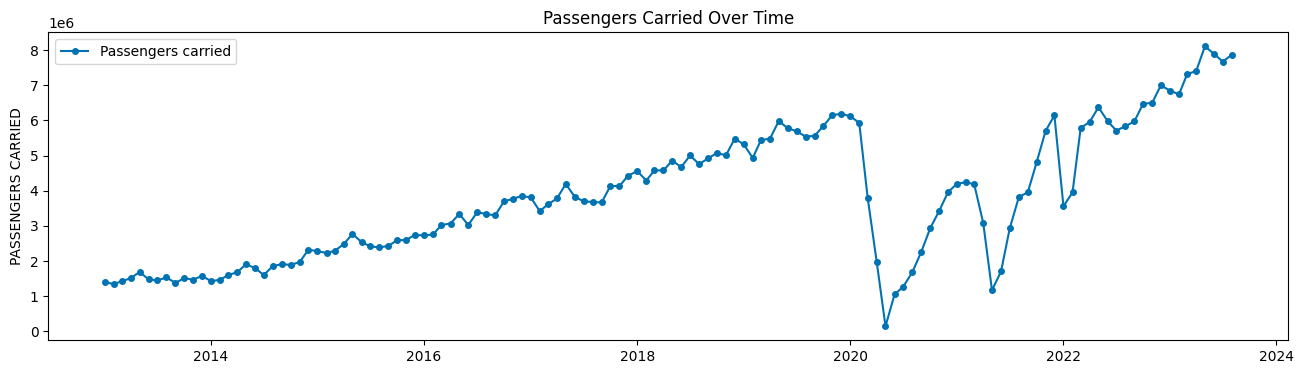

In [171]:
# Now plotting the data
plot_data(data)

In the plot aroundd 2020 , 2021 and 2022 , thier is sharp drop due to COVID-19 

They act as an outlier of the data

We can Also see their is a upward sloping trend in increase in number of passengers carried and this was followed also after the covid , So we can fill the data during the covid to follow that trend 

Shaper drop starts from MAY 2020, and Continues till OCT 2020

Also, a sharp drop is their during 2nd covid wave, OCT 2021 to MAR 2022,expect the DEC 2021 and NOV 2021 Data

So , the first step is to reomve this outliers 


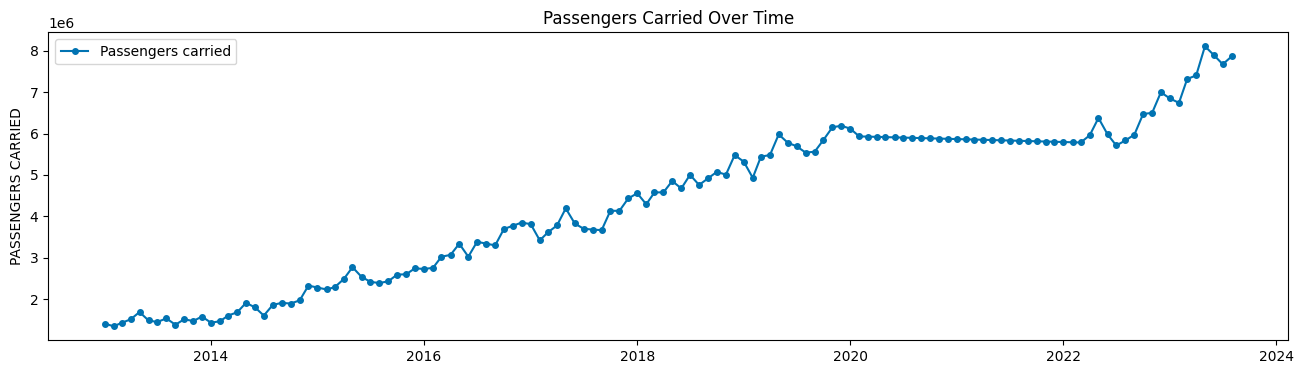

In [172]:
# Storing last month to use it for reindexing while saving the forecasted data 
last_month = data.index[-1]
# Now neglecting the covid data as it performs like an outlier to out model 
outlier_date = pd.date_range(start = '2020-03-01' , end = '2022-02-01',freq='MS')
# Now remove this from the data 
data = data.loc[~data.index.isin(outlier_date)]
plot_data(data)

Now on Plotting the data it is observed that the covid data deleted is plotted as horizontal line, as creating a gap could lead to problem in model also 

So, for this reset the date of the remaining data after the covid.

Then , forecast futher and after that while reporting the answer change the date appropriately 

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='PASSENGERS CARRIED'>)

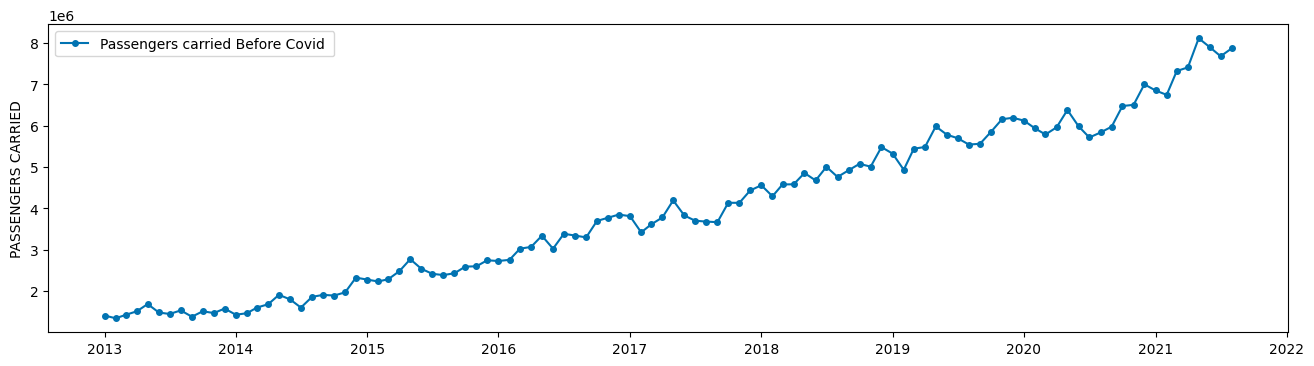

In [173]:
# Now resetting the index of the remaning data 
resetted_index = pd.date_range(start='2013-01-01',periods = len(data), freq='MS')
data.index = resetted_index
plot_series(data, labels=['Passengers carried Before Covid '])

Now This data doesn't seem stationary as their is an upward trend, So to encounter this we would need to difference the data

In [123]:
opt_d = optimal_d(data)
diff_data = difference_data(data,opt_d)

ADF Statistic: -8.686437
p-value: 0.000000
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583
Stationary
4.151190957660585e-14
Optimal d value is 1


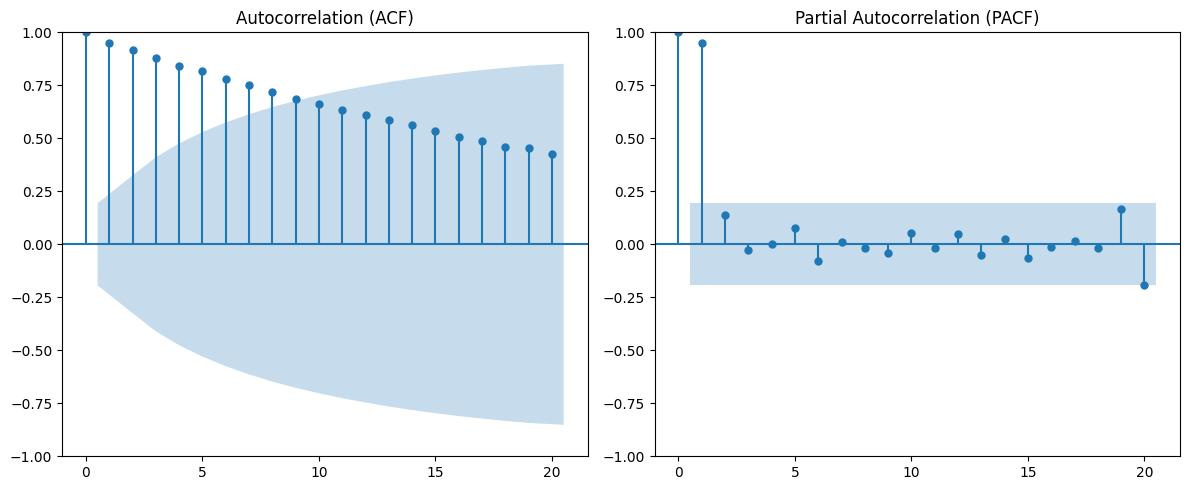

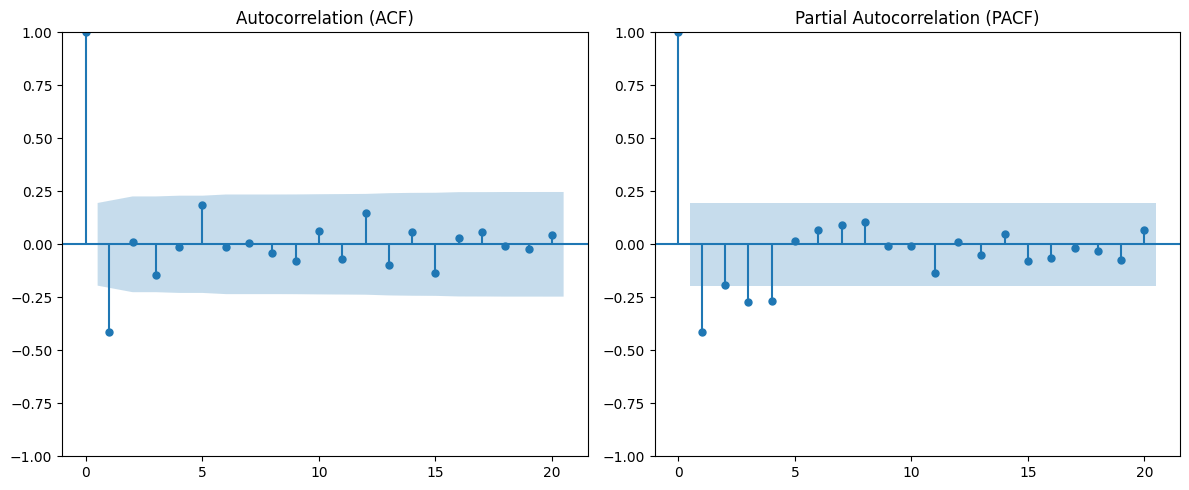

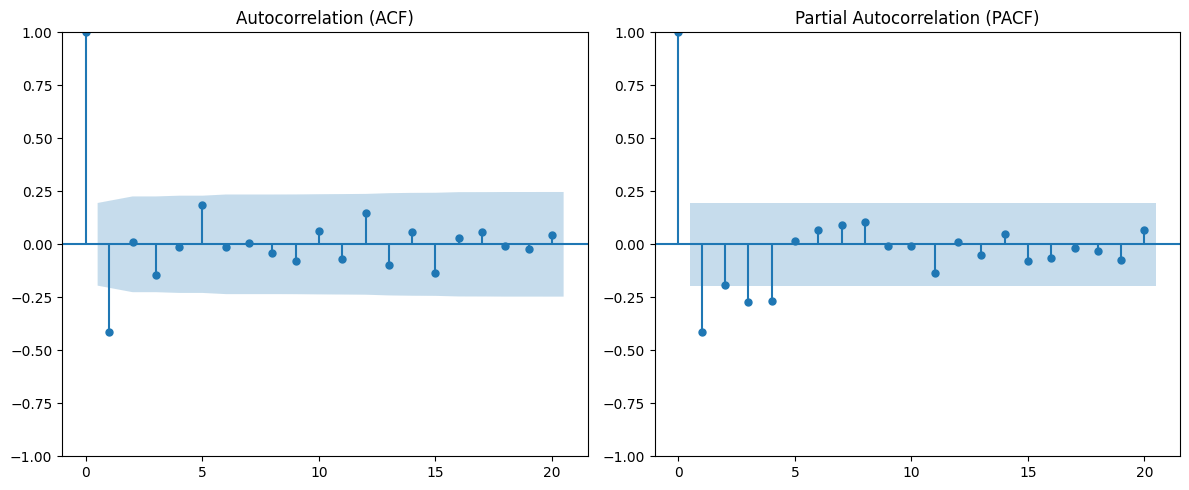

In [124]:
# Now plot the acf and pacf for the differnence and the normal data 
lags = 20 
plot_acf_pacf(data,lags)
plot_acf_pacf(diff_data,lags)
plot_acf_pacf(data.diff().dropna(),lags)

In [125]:
def forecast_accuracy(forecast, actual):
    forecast  = forecast.values
    actual = actual.values.reshape(-1)
    # mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    # me = np.mean(forecast - actual)             # ME
    # mae = np.mean(np.abs(forecast - actual))    # MAE
    # mpe = np.mean((forecast - actual)/actual)   # MPE
    # rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    # mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    # maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    # minmax = 1 - np.mean(mins/maxs)             # minmax
    print(corr)
    return corr

In [126]:
# Now find the optimal p ,q ,d using training and test of the data 

best_p = 0
best_d = 0 
best_q = 0 
best_mape = 10000

for d in range(0,2) : 
    for p in range(1,20) : 
        for q in range(1,5) : 
            str_w = str(p)+"_"+str(d)+"_"+str(q)
            model_fitted , forecasted_value_test , test_data= arima_modelling(data,p,d,q)
            mape_curr = MAPE(forecasted_value_test.values.reshape(-1),test_data.values.reshape(-1))
            if mape_curr < best_mape : 
                best_mape = mape_curr
                best_p = p 
                best_d = d 
                best_q = q

KeyboardInterrupt: 

In [98]:
print(best_p,best_d,best_q)

19 1 3


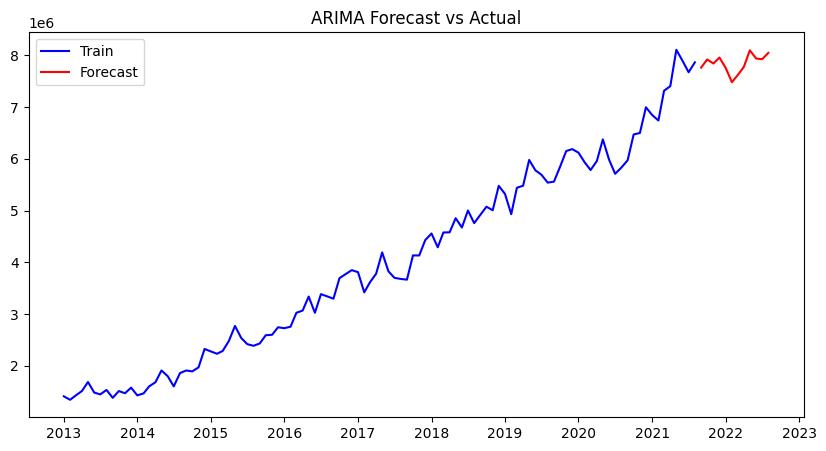

In [99]:
model_fitted = fit_arima(data,best_p,best_d,best_q)

# Now forecast for the next 12 months 
predict_data(data,12,model_fitted,last_month)
plot_forecasted_Data(data,12,model_fitted)